In [15]:
import sys; sys.path.append("/gaozhangyang/experiments/DiffSDS")
from utils.data_tools import ReadPDB
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import stats

## 1. 角度分布

In [16]:
def kl_from_empirical(
    u: np.ndarray, v: np.ndarray, nbins: int = 100, pseudocount: bool = False
) -> float:
    """
    Compute the KL divergence between two empirical distributions u and v.
    Discretizes the u and v distributions using nbins bins
    """
    min_val = min(np.min(u), np.min(v))
    max_val = max(np.max(u), np.max(v))

    bins = np.linspace(min_val, max_val, nbins + 1)
    if pseudocount:
        u = np.concatenate((u, bins))
        v = np.concatenate((v, bins))
    u_hist, _u_bin_edges = np.histogram(u, bins=bins, density=True)
    v_hist, _v_bin_edges = np.histogram(v, bins=bins, density=True)

    # Compute KL divergence
    # https://stackoverflow.com/questions/63369974/3-functions-for-computing-relative-entropy-in-scipy-whats-the-difference
    kl = stats.entropy(u_hist, v_hist)
    return kl


def compute_kl(dist, q1_dist, nbins=200):
    epsilon = 0.00001
    ref_hist, ref_bins = np.histogram(dist, bins=nbins, density=True)
    q1_hist, q1_bins = np.histogram(q1_dist, bins=nbins, density=True)


    def to_hist_with_orig_bins(targ_hist, targ_bins, orig_hist, orig_bins):
        targ_v = 0.0
        targ_i = 0
        targ_bin = targ_bins[0]
        ret_hist = np.zeros_like(orig_hist)

        for i, orig_bin in enumerate(orig_bins[:-1]):
            if targ_bin <= orig_bin:
                if targ_i < len(targ_bins) - 1:
                    targ_v = targ_hist[targ_i]
                    targ_i += 1
                    targ_bin = targ_bins[targ_i]
                else:
                    targ_v = 0.0
                    targ_bin = orig_bin.max() + 1.0

            ret_hist[i] = targ_v

        return ret_hist


    c_q1_hist = to_hist_with_orig_bins(q1_hist, q1_bins, ref_hist, ref_bins)

    pad_ref_bins = np.pad(ref_bins, [1, 0], 'constant')
    sumd = np.sum((ref_bins - pad_ref_bins[:-1])[1:])


    ref_hist = (ref_hist + epsilon) / (1.0 + epsilon * sumd)
    c_q1_hist = (c_q1_hist + epsilon) / (1.0 + epsilon * sumd)

    kl_c_q1 = np.sum(ref_hist * np.log(ref_hist / c_q1_hist))
    return kl_c_q1

In [17]:
def load_pdb(fname):
    ref_index, angles, coords, seqs, attn_mask, b_factor = ReadPDB.read_pdb(fname)
    mask = (b_factor==100)
    mask_idx = mask.nonzero()[0]
    left = mask_idx[0]
    right = mask_idx[-1]
    max_idx = (b_factor>0).nonzero()[0][-1]
    
    return angles, left, right, max_idx, b_factor




def get_angles(pdb_name):
    diffsds_fname = f"/gaozhangyang/experiments/DiffSDS/results/DiffSDS_sampling_9500/pred_{pdb_name}.pdb"
    foldingdiff_fname = f"/gaozhangyang/experiments/DiffSDS/results/CFoldingDiff_sampling/pred_{pdb_name}.pdb" 
    true_frame = f"/gaozhangyang/experiments/DiffSDS/results/DiffSDS_sampling/raw_{pdb_name}.pdb"
        
    diffsds_angles, left, right, max_idx, b_factor = load_pdb(diffsds_fname)
    foldingdiff_angles, _, _, _, _ = load_pdb(foldingdiff_fname)
    # _, RFDesign_angles, _, _, _, _ = ReadPDB.read_pdb(RFDesign_fname)
    true_angles, _, _, _, _ = load_pdb(true_frame)

    
    return (right-left)+1, max_idx+1, diffsds_angles[left:right], foldingdiff_angles[left:right],  true_angles[left:right]

    # return (right-left)+1, max_idx+1, diffsds_angles[:max_idx], foldingdiff_angles[:max_idx], RFDesign_angles[:max_idx], true_angles[:max_idx]

In [18]:
pdb_name_list = os.listdir("/gaozhangyang/experiments/DiffSDS/results/DiffSDS_sampling/")
pdb_name_list = [one for one in pdb_name_list if "pred_" in one]
pdb_name_list = [one.split("_")[-1][:-4] for one in pdb_name_list]

In [19]:
diffsds_angles, foldingdiff_angles, True_angles = [],  [], []
for i, pdb_name in enumerate(tqdm(pdb_name_list)):
    mask_len, all_len, diffsds_angle, foldingdiff_angle, True_angle = get_angles(pdb_name)
    diffsds_angles.append(diffsds_angle)
    foldingdiff_angles.append(foldingdiff_angle)
    True_angles.append(True_angle)

diffsds_angles = np.concatenate(diffsds_angles)
foldingdiff_angles = np.concatenate(foldingdiff_angles)
True_angles = np.concatenate(True_angles)

100%|██████████| 378/378 [00:14<00:00, 26.64it/s]


In [7]:
foldingdiff_angles.mean(axis=0)

array([-1.6907643, -0.5906107, -2.6462235,  1.9569303,  2.0361042,
        2.1416926], dtype=float32)

In [25]:
diffsds_angles.mean(axis=0)

array([-0.9909667 ,  0.9483696 ,  0.94308335,  1.9406067 ,  2.063312  ,
        2.153803  ], dtype=float32)

In [9]:
True_angles.mean(axis=0)

array([-1.2812977 ,  0.37541163,  0.527517  ,  1.9424182 ,  2.0373824 ,
        2.1198928 ], dtype=float32)

KL, 	phi, 	27.55
KL, 	psi, 	18.21
KL, 	omega, 	35.96
KL, 	tau, 	418.63
KL, 	CA_C_1N, 	164.76
KL, 	C_1N_1CA, 	1337.72


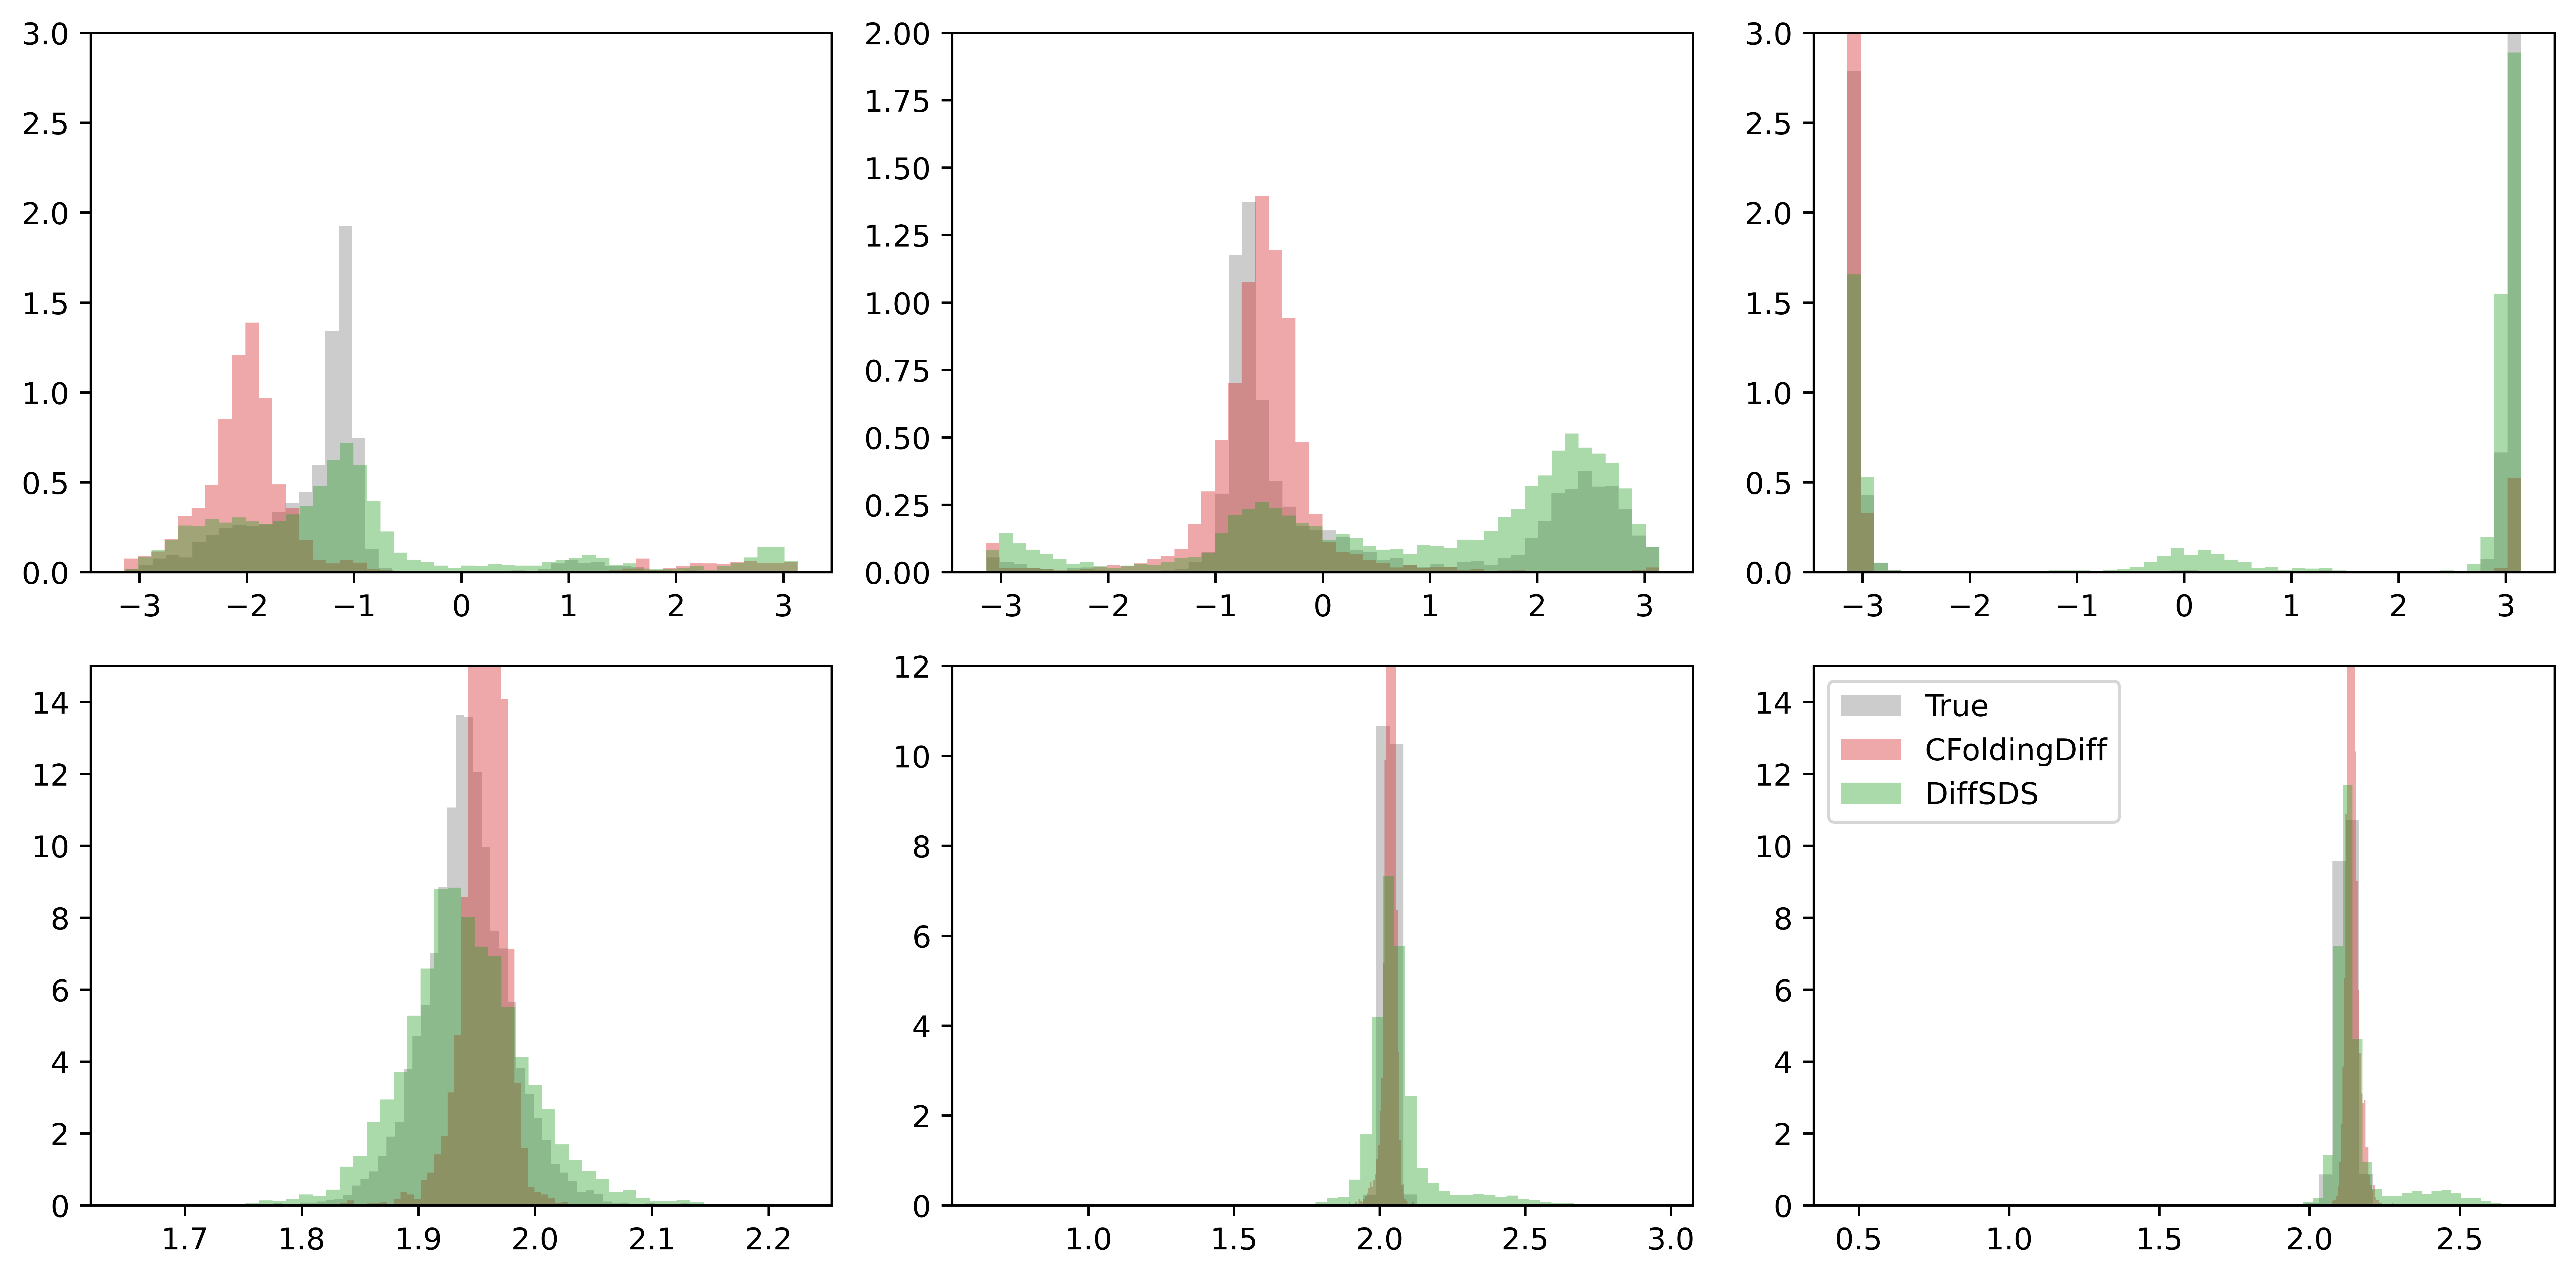

In [20]:
import matplotlib.pyplot as plt
n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6))
fig.set_dpi(800)

V_angles_names = ["phi", "psi", "omega", "tau", "CA_C_1N", "C_1N_1CA"]
height = [3,2,3,15,12,15]
for i, idx in enumerate([0,1,2,3,4,5]):
    axs[i//3, i%3].hist(True_angles[:,idx], bins=n_bins, alpha=0.4, density=True, label = "True", color = "gray")
    
    # axs[i//3, i%3].hist(RFDesign_angles[:,idx], bins=n_bins, alpha=0.4, density=True, label = "RFDesign", color = "C0")
    axs[i//3, i%3].hist(foldingdiff_angles[:,idx], bins=n_bins, alpha=0.4, density=True, label = "CFoldingDiff", color = "C3")
    axs[i//3, i%3].hist(diffsds_angles[:,idx], bins=n_bins, alpha=0.4, density=True, label = "DiffSDS", color = "C2")
    
    # axs[i//3, i%3].set_title('{}'.format(V_angles_names[idx]))
    axs[i//3, i%3].set_ylim([0, height[i]])
    
    kl = compute_kl( diffsds_angles[:,idx], True_angles[:,idx], 200)
    print("KL, \t{}, \t{:.2f}".format(V_angles_names[idx], kl))

plt.legend()

plt.savefig("./angles.png")


## 2. ramachandran graph

In [19]:
from astropy.visualization.mpl_normalize import ImageNormalize
import seaborn as sns
from matplotlib.colors import LogNorm
from astropy.visualization import LogStretch
import mpl_scatter_density

def plot_joint_kde(
    x_values, y_values, show_axes: bool = True, fname = None, **kwargs
):
    """
    Plot a density scatter plot (KDE) of the values. kwargs are passed to
    ax.set()
    Useful for plotting Ramachandran plot - x = phi, y = psi
    https://proteopedia.org/wiki/index.php/Ramachandran_Plots
    """
    fig, ax = plt.subplots(dpi=300)
    sns.kdeplot(x=x_values, y=y_values, levels=100, fill=True, norm=LogNorm(), ax=ax, common_norm=True, cbar=True)
    if show_axes:
        ax.axvline(0, color="grey", alpha=0.5)
        ax.axhline(0, color="grey", alpha=0.5)
    ax.set(**kwargs)
    if fname is not None:
        fig.savefig(fname, bbox_inches="tight")
    return fig


def plot_ramachandran(
    phi_values,
    psi_values,
    fname: str,
    annot_ss: bool = False,
    title: str = "",
    plot_type = "density_heatmap", 
):
    """Create Ramachandran plot for phi_psi"""
    if plot_type == "kde":
        fig = plot_joint_kde(
            phi_values,
            psi_values,
        )
        ax = fig.axes[0]
        ax.set_xlim(-3.67, 3.67)
        ax.set_ylim(-3.67, 3.67)
    elif plot_type == "density_heatmap":
        fig = plt.figure(dpi=800)
        # ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
        # norm = ImageNormalize(vmin=0.0, vmax=650, stretch=LogStretch())
        # ax.scatter_density(phi_values, psi_values, norm=norm, cmap=plt.cm.Blues)
        ax = fig.add_subplot(1, 1, 1)
        ax.scatter(phi_values, psi_values, s=2, alpha=0.3, marker="s", linewidth=0)
        
    else:
        raise NotImplementedError(f"Cannot plot type: {plot_type}")
    if annot_ss:
        # https://matplotlib.org/stable/tutorials/text/annotations.html
        ram_annot_arrows = dict(
            facecolor="black", shrink=0.05, headwidth=6.0, width=1.5
        )
        ax.annotate(
            r"$\alpha$ helix, LH",
            xy=(1.2, 0.5),
            xycoords="data",
            xytext=(1.7, 1.2),
            textcoords="data",
            arrowprops=ram_annot_arrows,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=14,
        )
        ax.annotate(
            r"$\alpha$ helix, RH",
            xy=(-1.1, -0.6),
            xycoords="data",
            xytext=(-1.7, -1.9),
            textcoords="data",
            arrowprops=ram_annot_arrows,
            horizontalalignment="right",
            verticalalignment="center",
            fontsize=14,
        )
        ax.annotate(
            r"$\beta$ sheet",
            xy=(-1.67, 2.25),
            xycoords="data",
            xytext=(-0.9, 2.9),
            textcoords="data",
            arrowprops=ram_annot_arrows,
            horizontalalignment="left",
            verticalalignment="center",
            fontsize=14,
        )
    ax.set_xlabel("$\phi$ (radians)", fontsize=14)
    ax.set_ylabel("$\psi$ (radians)", fontsize=14)
    if title:
        ax.set_title(title, fontsize=16)
    fig.savefig(fname, bbox_inches="tight")

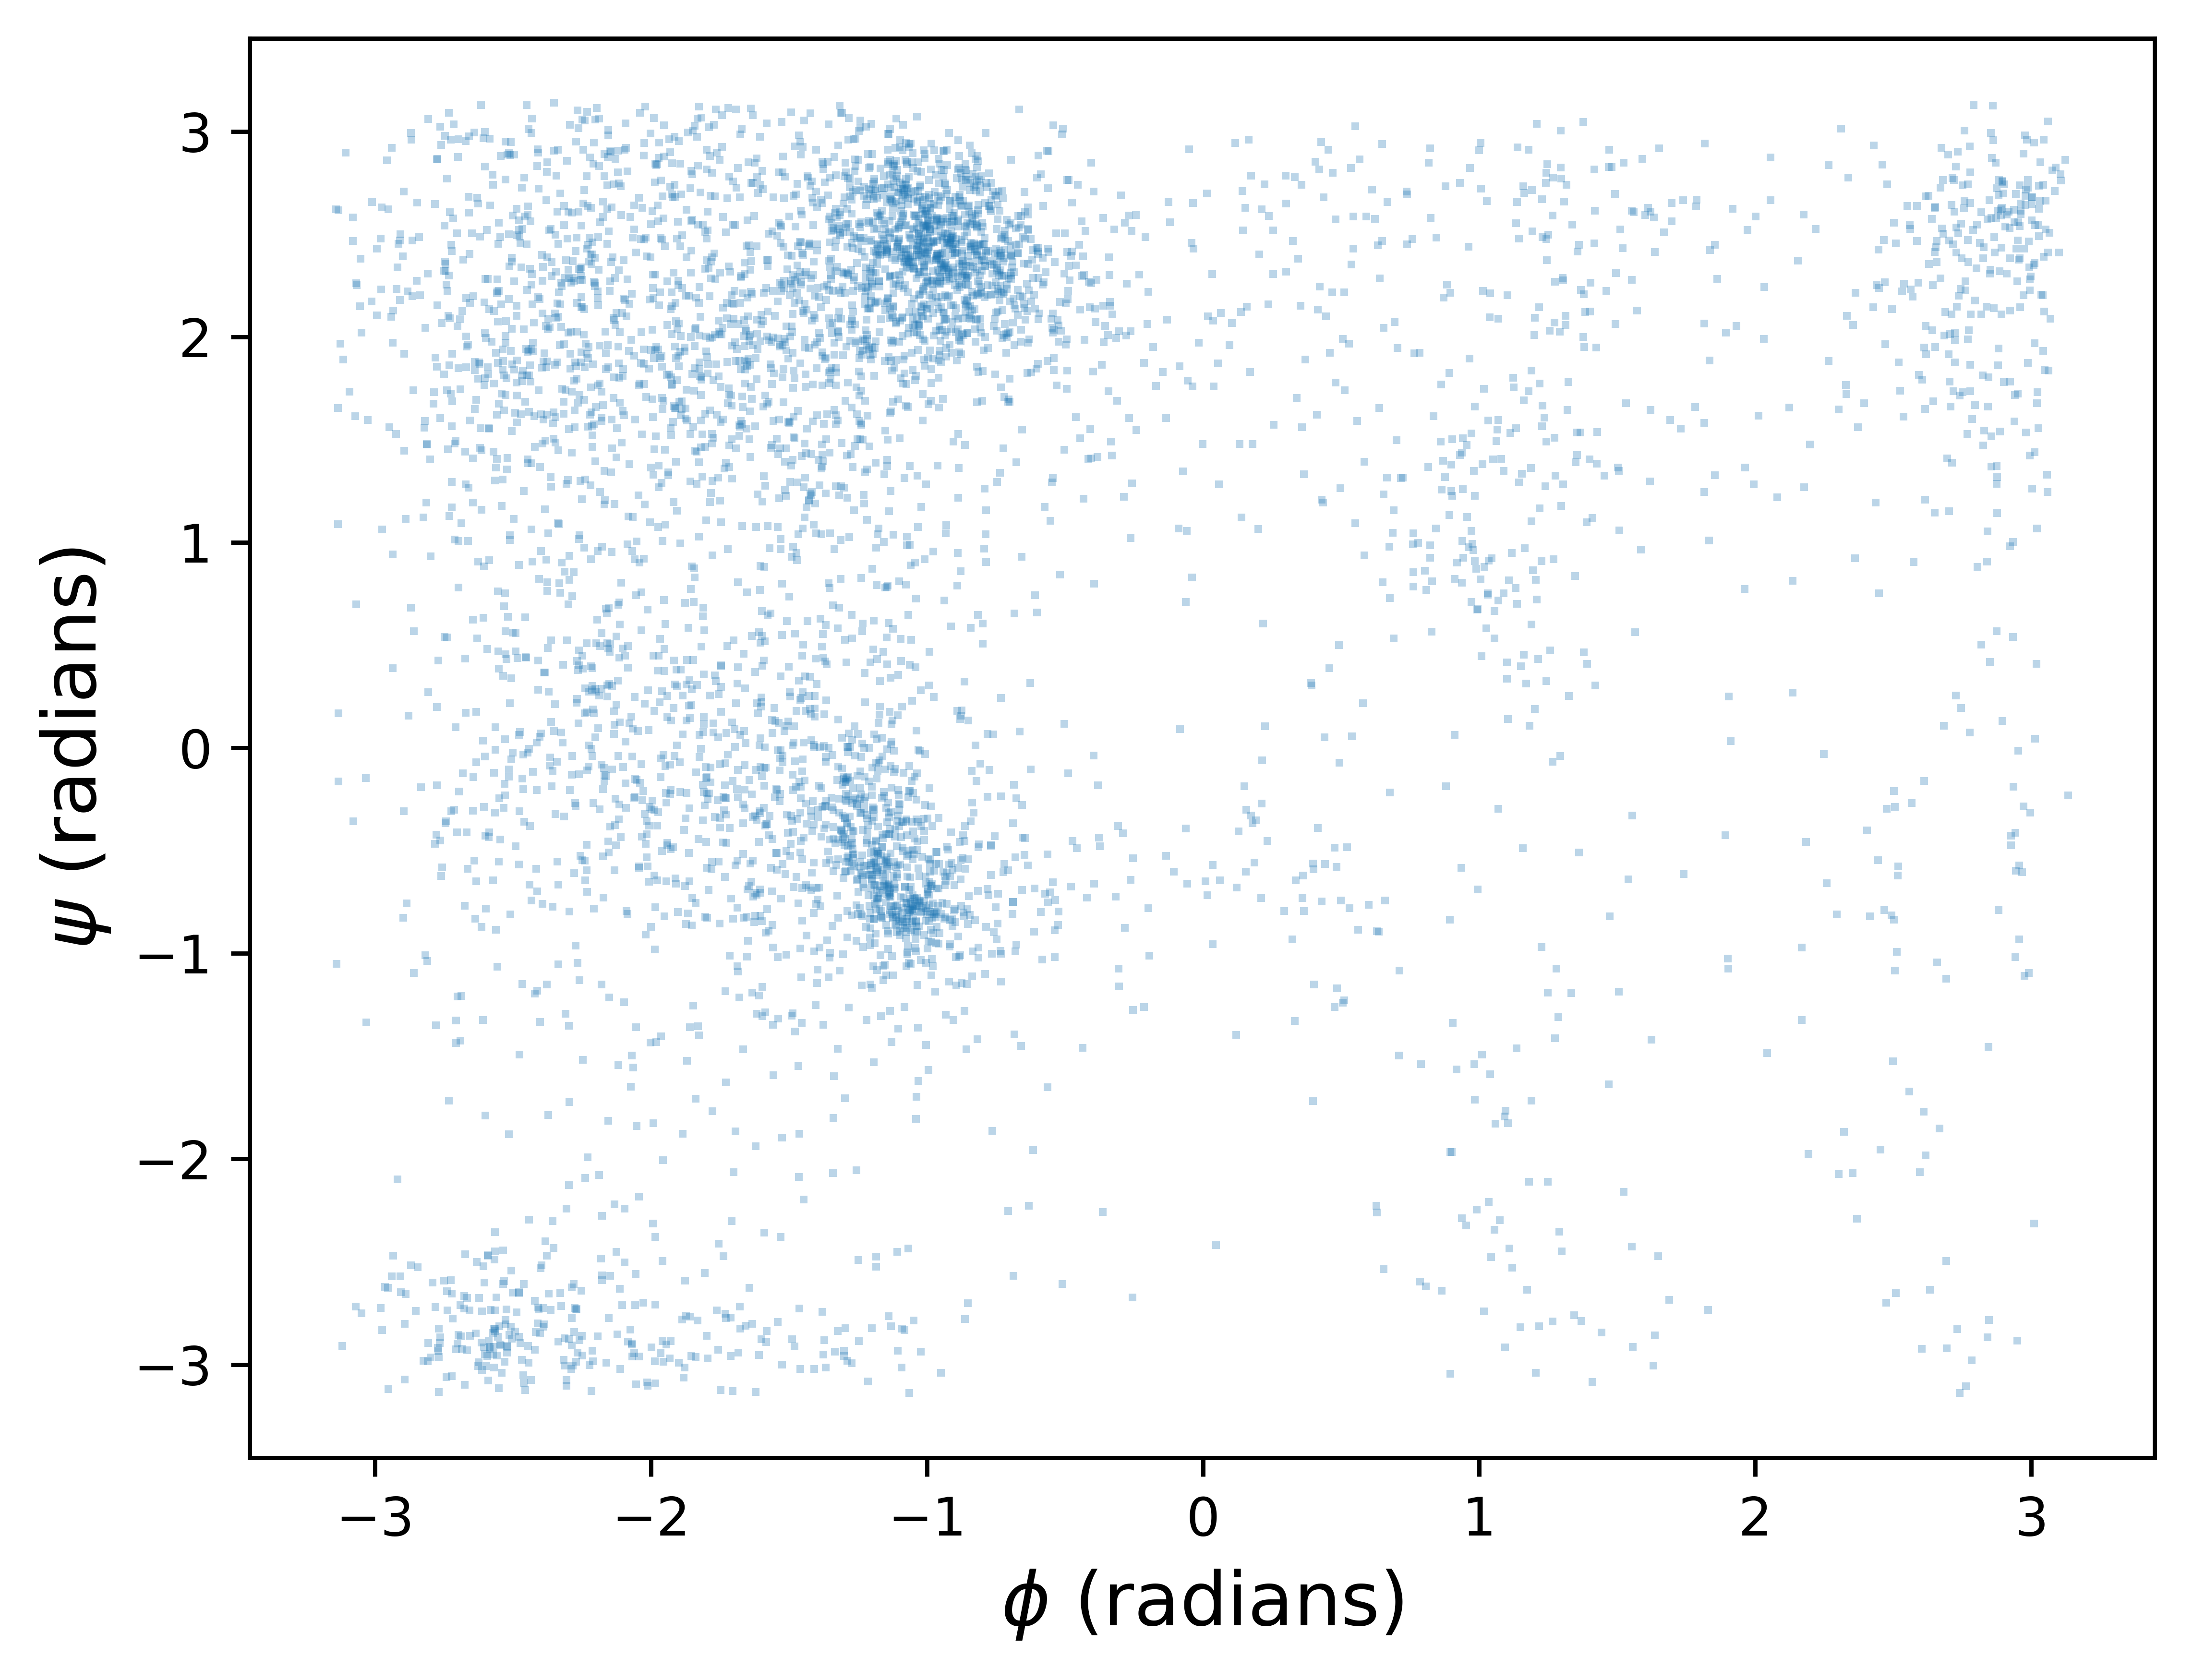

In [20]:
plot_ramachandran(diffsds_angles[:,0], diffsds_angles[:,1], "DiffSDS_ramachandran")

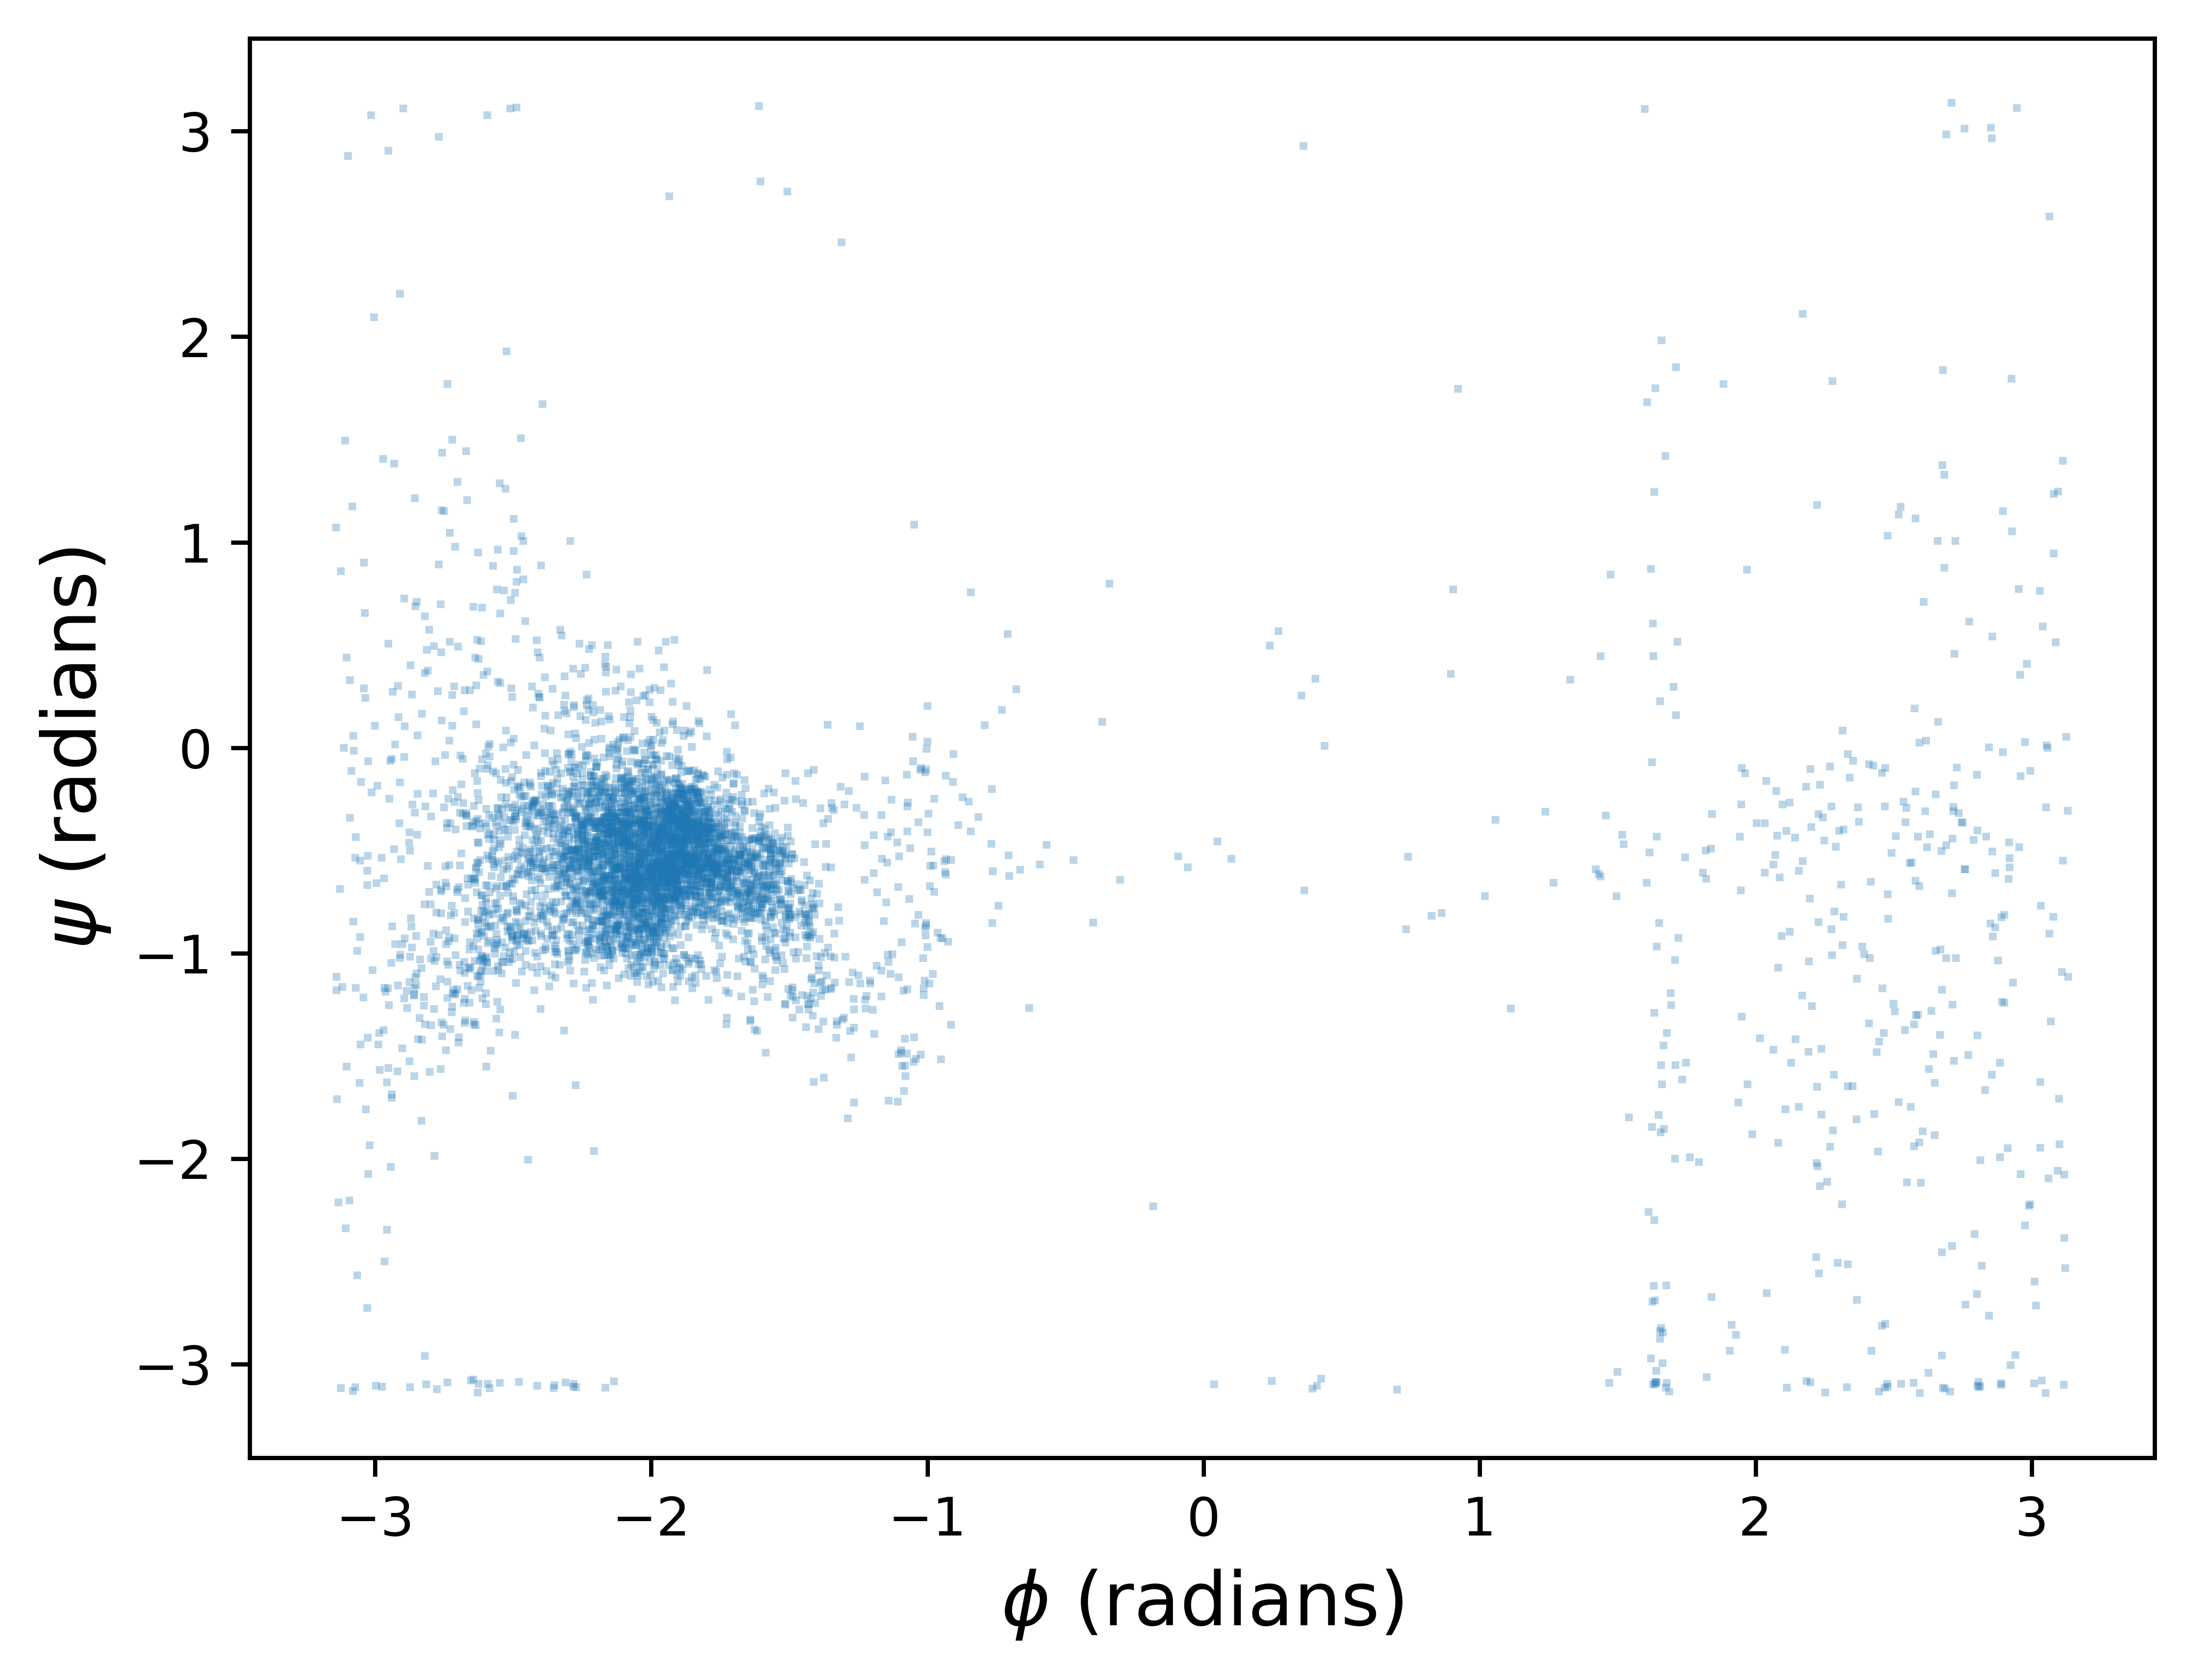

In [13]:
plot_ramachandran(foldingdiff_angles[:,0], foldingdiff_angles[:,1], "CFoldingDiff_ramachandran")

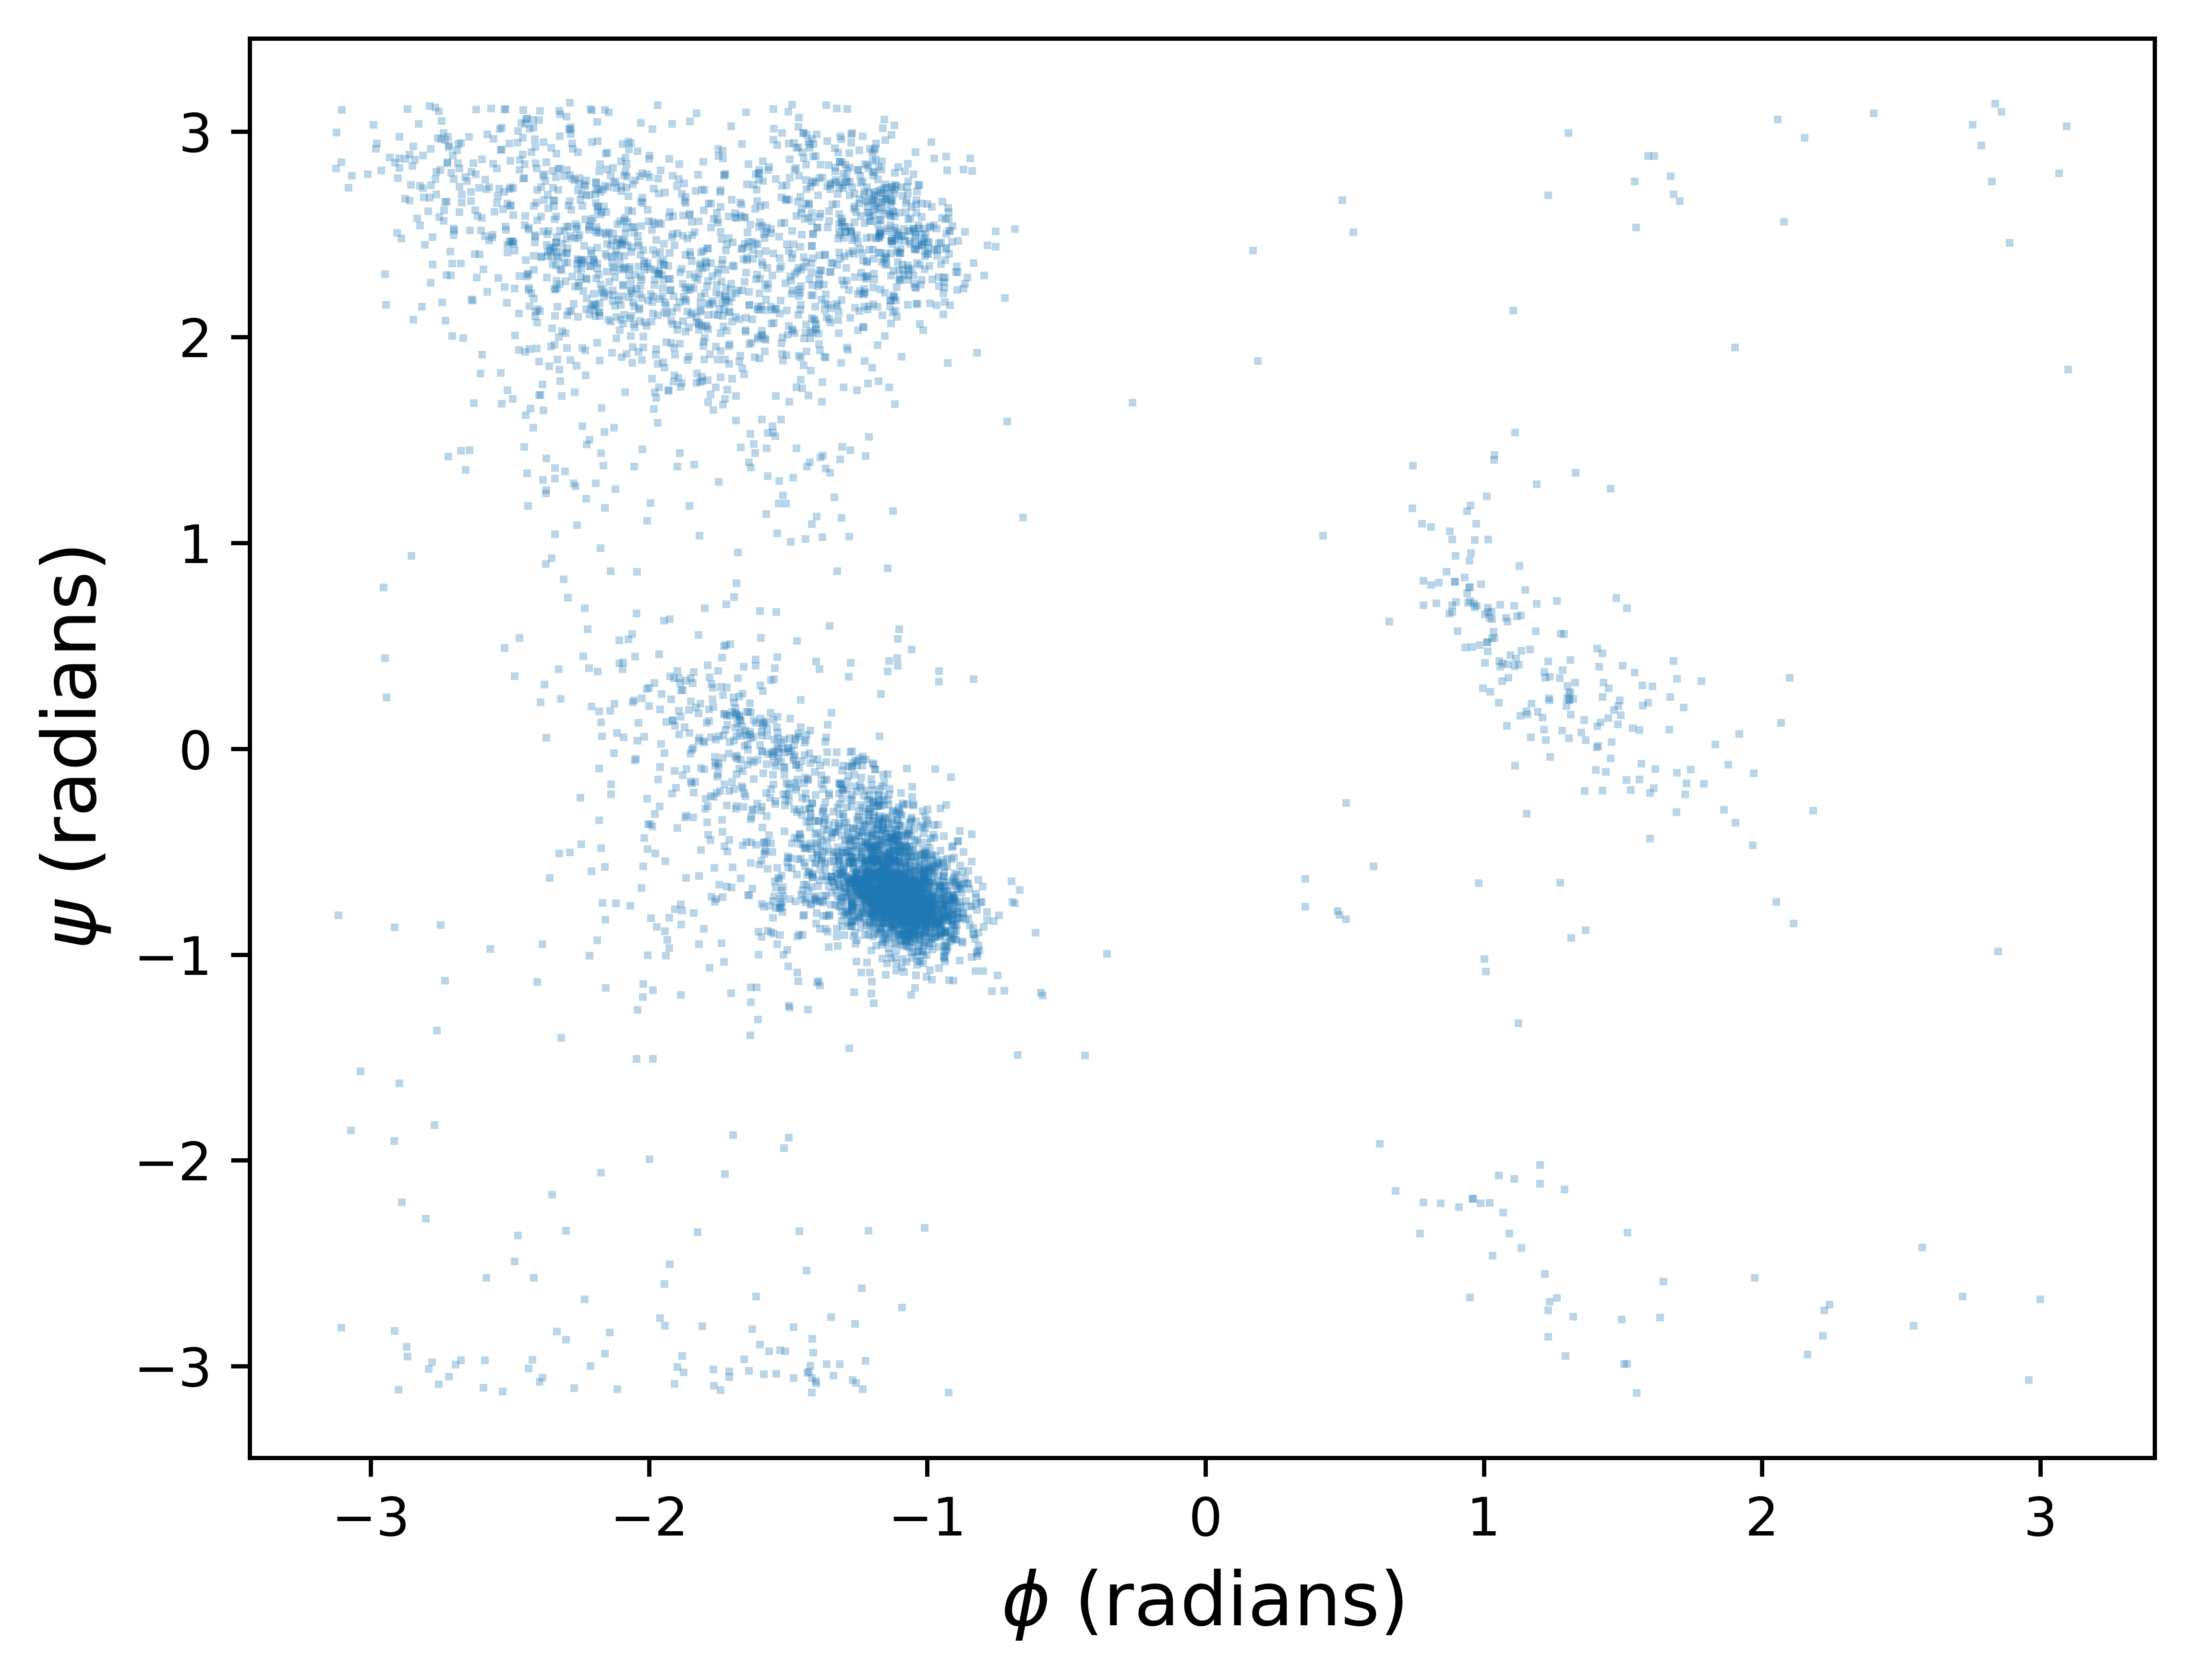

In [14]:
plot_ramachandran(True_angles[:,0], True_angles[:,1], "True_ramachandran")

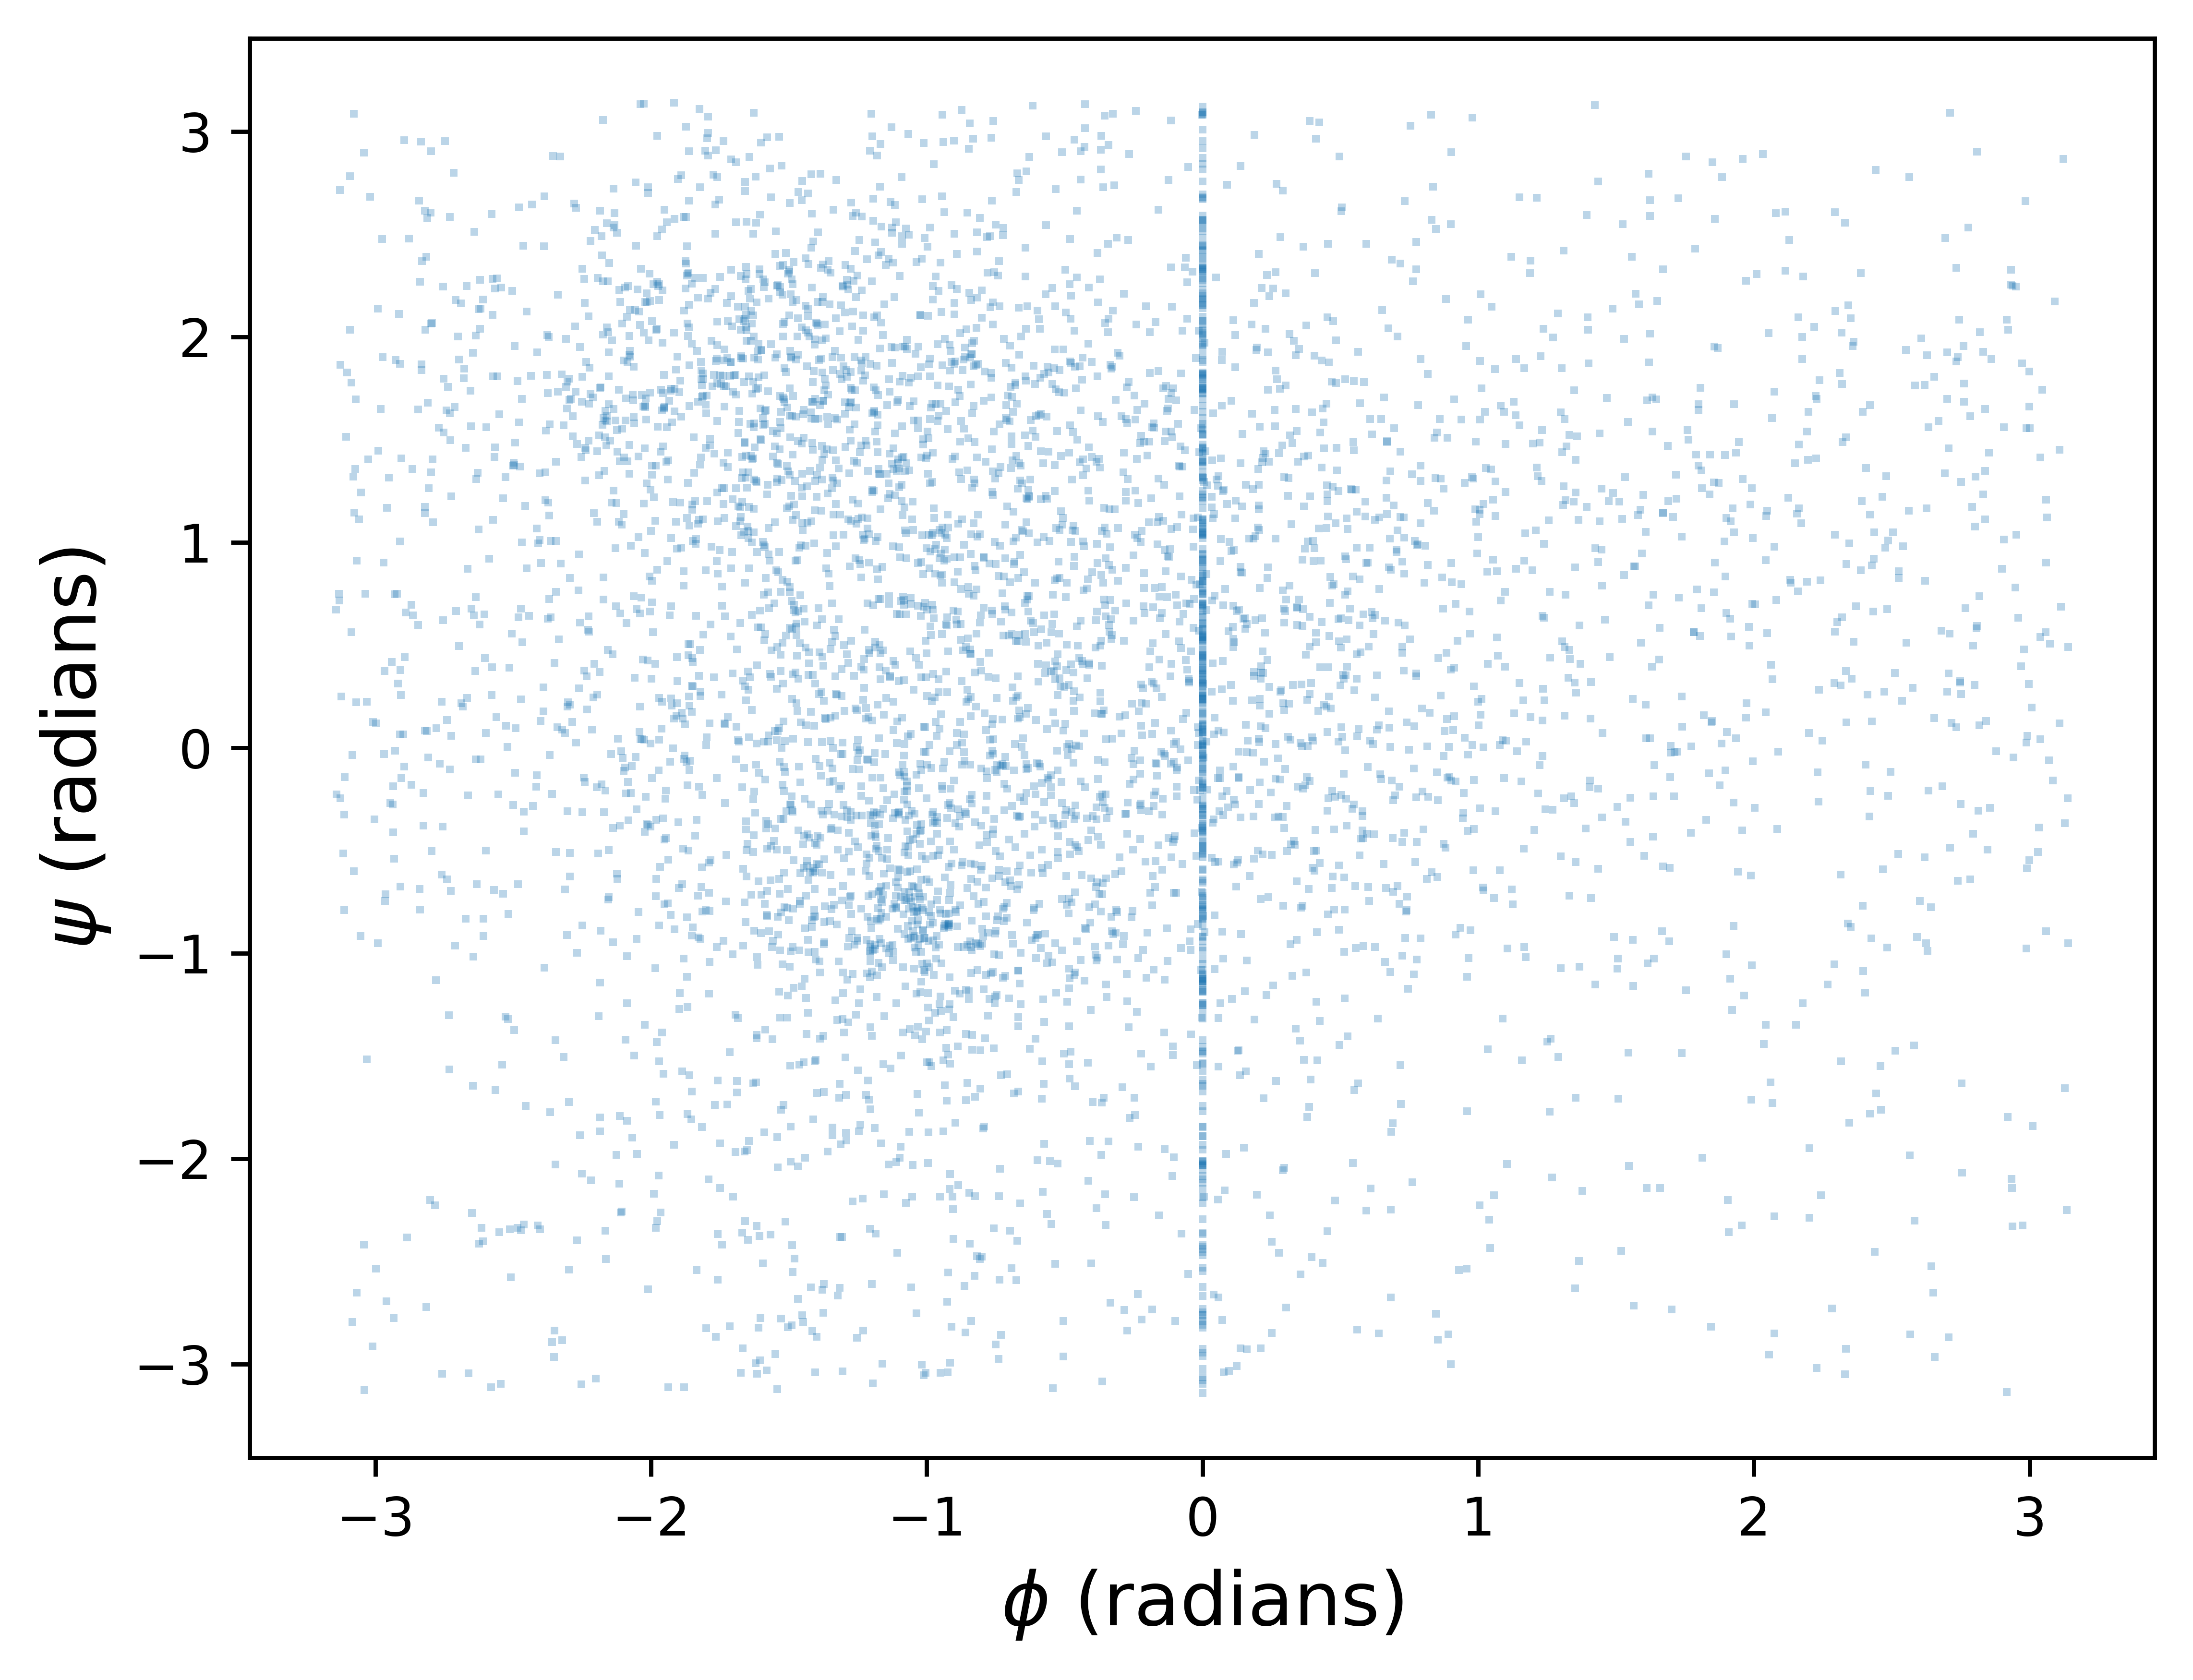

In [84]:
plot_ramachandran(RFDesign_angles[:,0], RFDesign_angles[:,1], "RFDesign_ramachandran")

# rebuttal

In [41]:
import torch

In [54]:
angles = torch.load("/gaozhangyang/experiments/ProreinBinder/results/cfoldingdiff_angles.pt")

phi_true tensor(0.1243)
phi_pred tensor(-0.1208)
psi_true tensor(0.3513)
psi_pred tensor(0.8323)
omega_true tensor(-0.0107)
omega_pred tensor(-0.1127)
tau_true tensor(0.0022)
tau_pred tensor(-0.1489)
CA_C_1N_true tensor(0.0016)
CA_C_1N_pred tensor(0.0094)
C_1N_1CA_true tensor(-0.0026)
C_1N_1CA_pred tensor(0.1338)


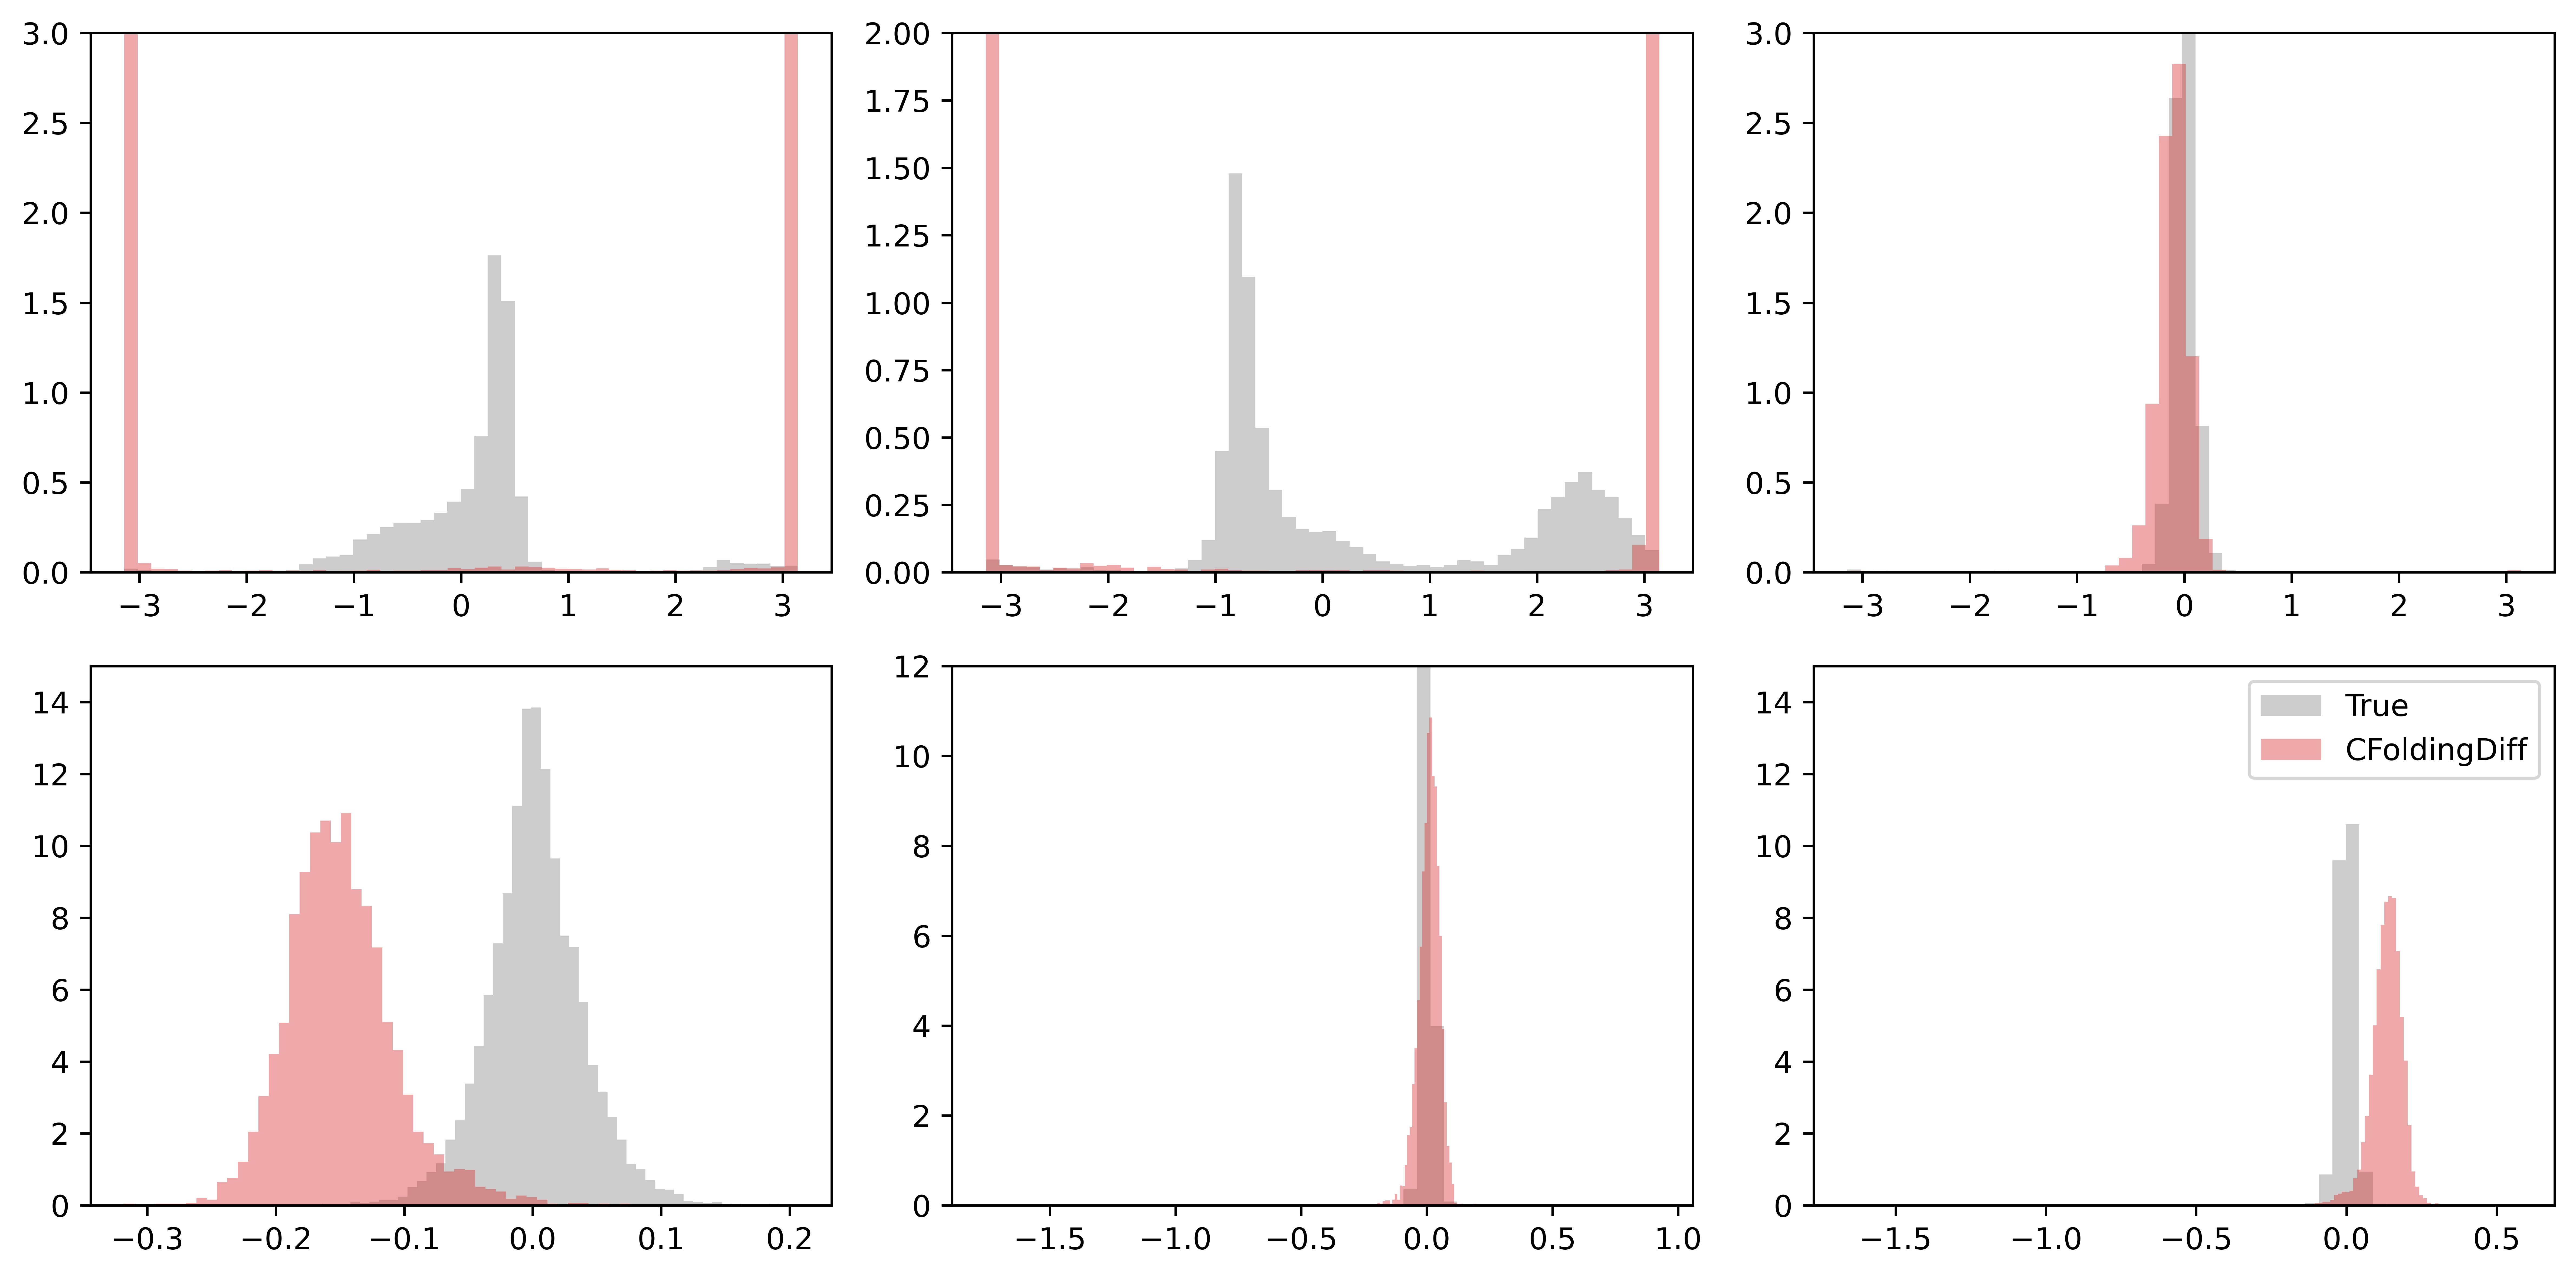

In [60]:
import matplotlib.pyplot as plt
n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6))
fig.set_dpi(800)

V_angles_names = ["phi", "psi", "omega", "tau", "CA_C_1N", "C_1N_1CA"]
height = [3,2,3,15,12,15]
for i, idx in enumerate([0,1,2,3,4,5]):
    name = V_angles_names[idx]
    true_val = angles[f"{name}_true"]
    pred_val = angles[f"{name}_pred"]
    if name == 'psi':
        pred_val = to_real(pred_val+0.03)
    axs[i//3, i%3].hist(true_val, bins=n_bins, alpha=0.4, density=True, label = "True", color = "gray")
    axs[i//3, i%3].hist(pred_val, bins=n_bins, alpha=0.4, density=True, label = "CFoldingDiff", color = "C3")
    
    print(f"{name}_true", true_val.mean())
    print(f"{name}_pred", pred_val.mean())
    
    axs[i//3, i%3].set_ylim([0, height[i]])
    
plt.legend()

plt.savefig("/gaozhangyang/experiments/ProreinBinder/evaluate/angles_normalized.png")

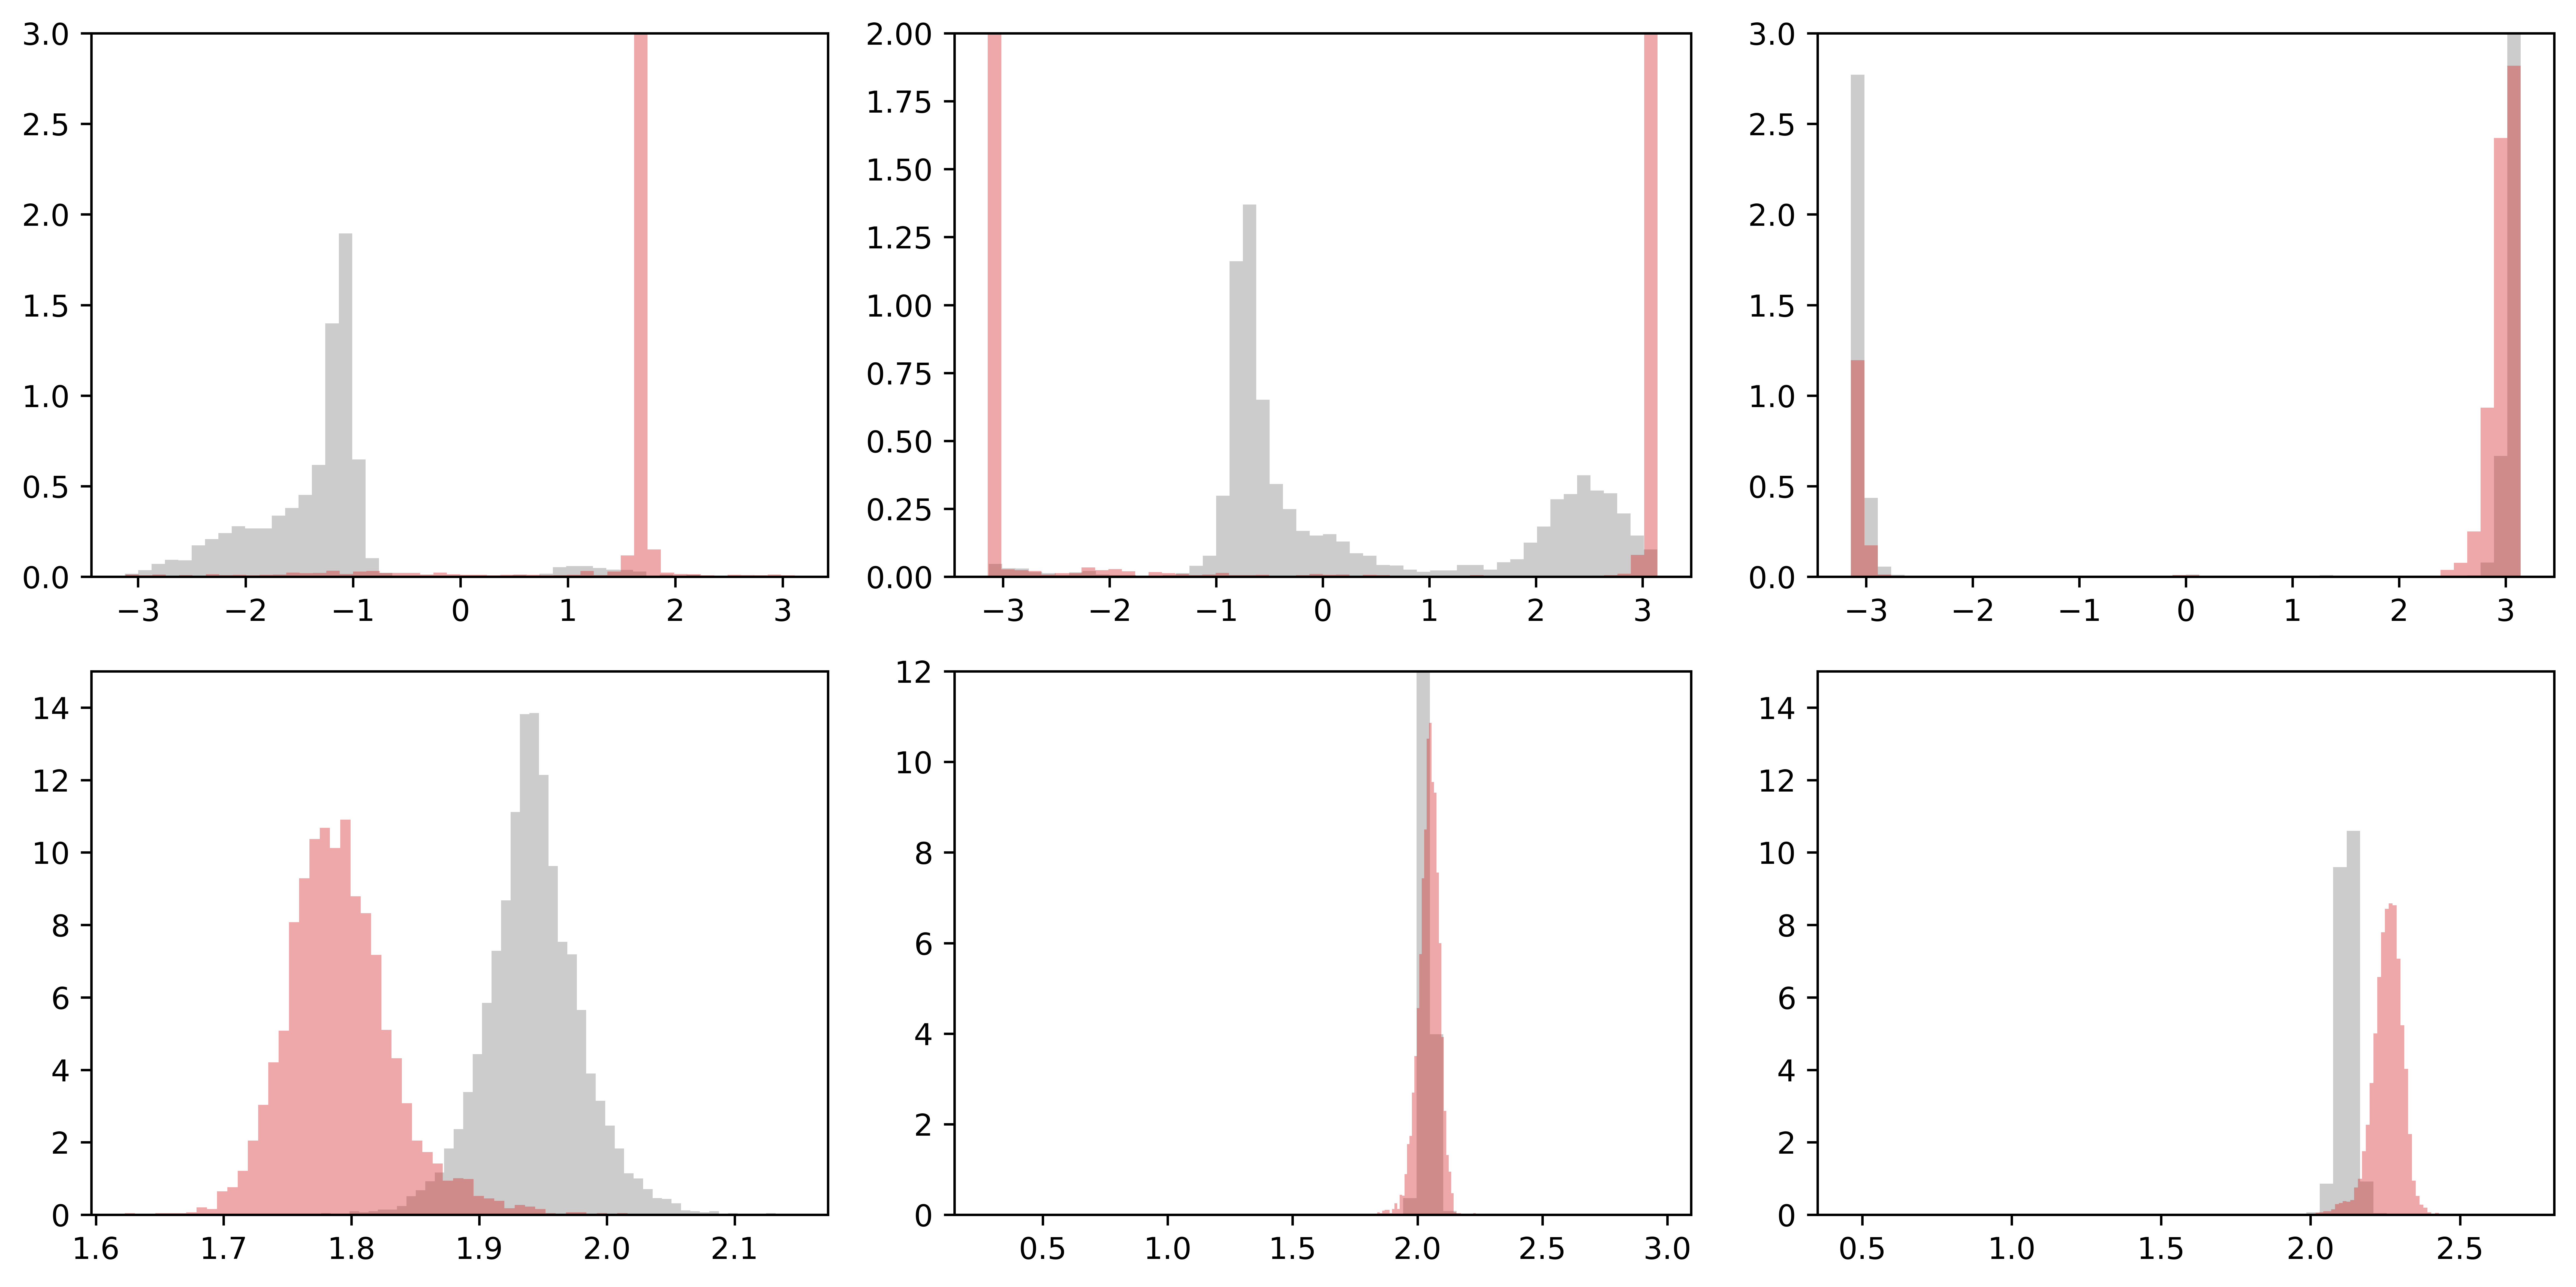

In [45]:
from utils import modulo_with_wrapped_range as to_real
import copy

n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6))
fig.set_dpi(800)


shifted_angles = copy.deepcopy(angles)
shifted_angles['phi_true'] = to_real(shifted_angles['phi_true']+angles['means'][0])
shifted_angles['psi_true'] = to_real(shifted_angles['psi_true']+angles['means'][1])
shifted_angles['omega_true'] = to_real(shifted_angles['omega_true']+angles['means'][2])
shifted_angles['tau_true'] = to_real(shifted_angles['tau_true']+angles['means'][3])
shifted_angles['CA_C_1N_true'] = to_real(shifted_angles['CA_C_1N_true']+angles['means'][4])
shifted_angles['C_1N_1CA_true'] = to_real(shifted_angles['C_1N_1CA_true']+angles['means'][5])

shifted_angles['phi_pred'] = to_real(shifted_angles['phi_pred']+angles['means'][0])
shifted_angles['psi_pred'] = to_real(shifted_angles['psi_pred']+angles['means'][1])
shifted_angles['omega_pred'] = to_real(shifted_angles['omega_pred']+angles['means'][2])
shifted_angles['tau_pred'] = to_real(shifted_angles['tau_pred']+angles['means'][3])
shifted_angles['CA_C_1N_pred'] = to_real(shifted_angles['CA_C_1N_pred']+angles['means'][4])
shifted_angles['C_1N_1CA_pred'] = to_real(shifted_angles['C_1N_1CA_pred']+angles['means'][5])



V_angles_names = ["phi", "psi", "omega", "tau", "CA_C_1N", "C_1N_1CA"]
height = [3,2,3,15,12,15]
for i, idx in enumerate([0,1,2,3,4,5]):
    name = V_angles_names[idx]
    axs[i//3, i%3].hist(shifted_angles[f"{name}_true"], bins=n_bins, alpha=0.4, density=True, label = "True", color = "gray")
    axs[i//3, i%3].hist(shifted_angles[f"{name}_pred"], bins=n_bins, alpha=0.4, density=True, label = "CFoldingDiff", color = "C3")
    
    axs[i//3, i%3].set_ylim([0, height[i]])

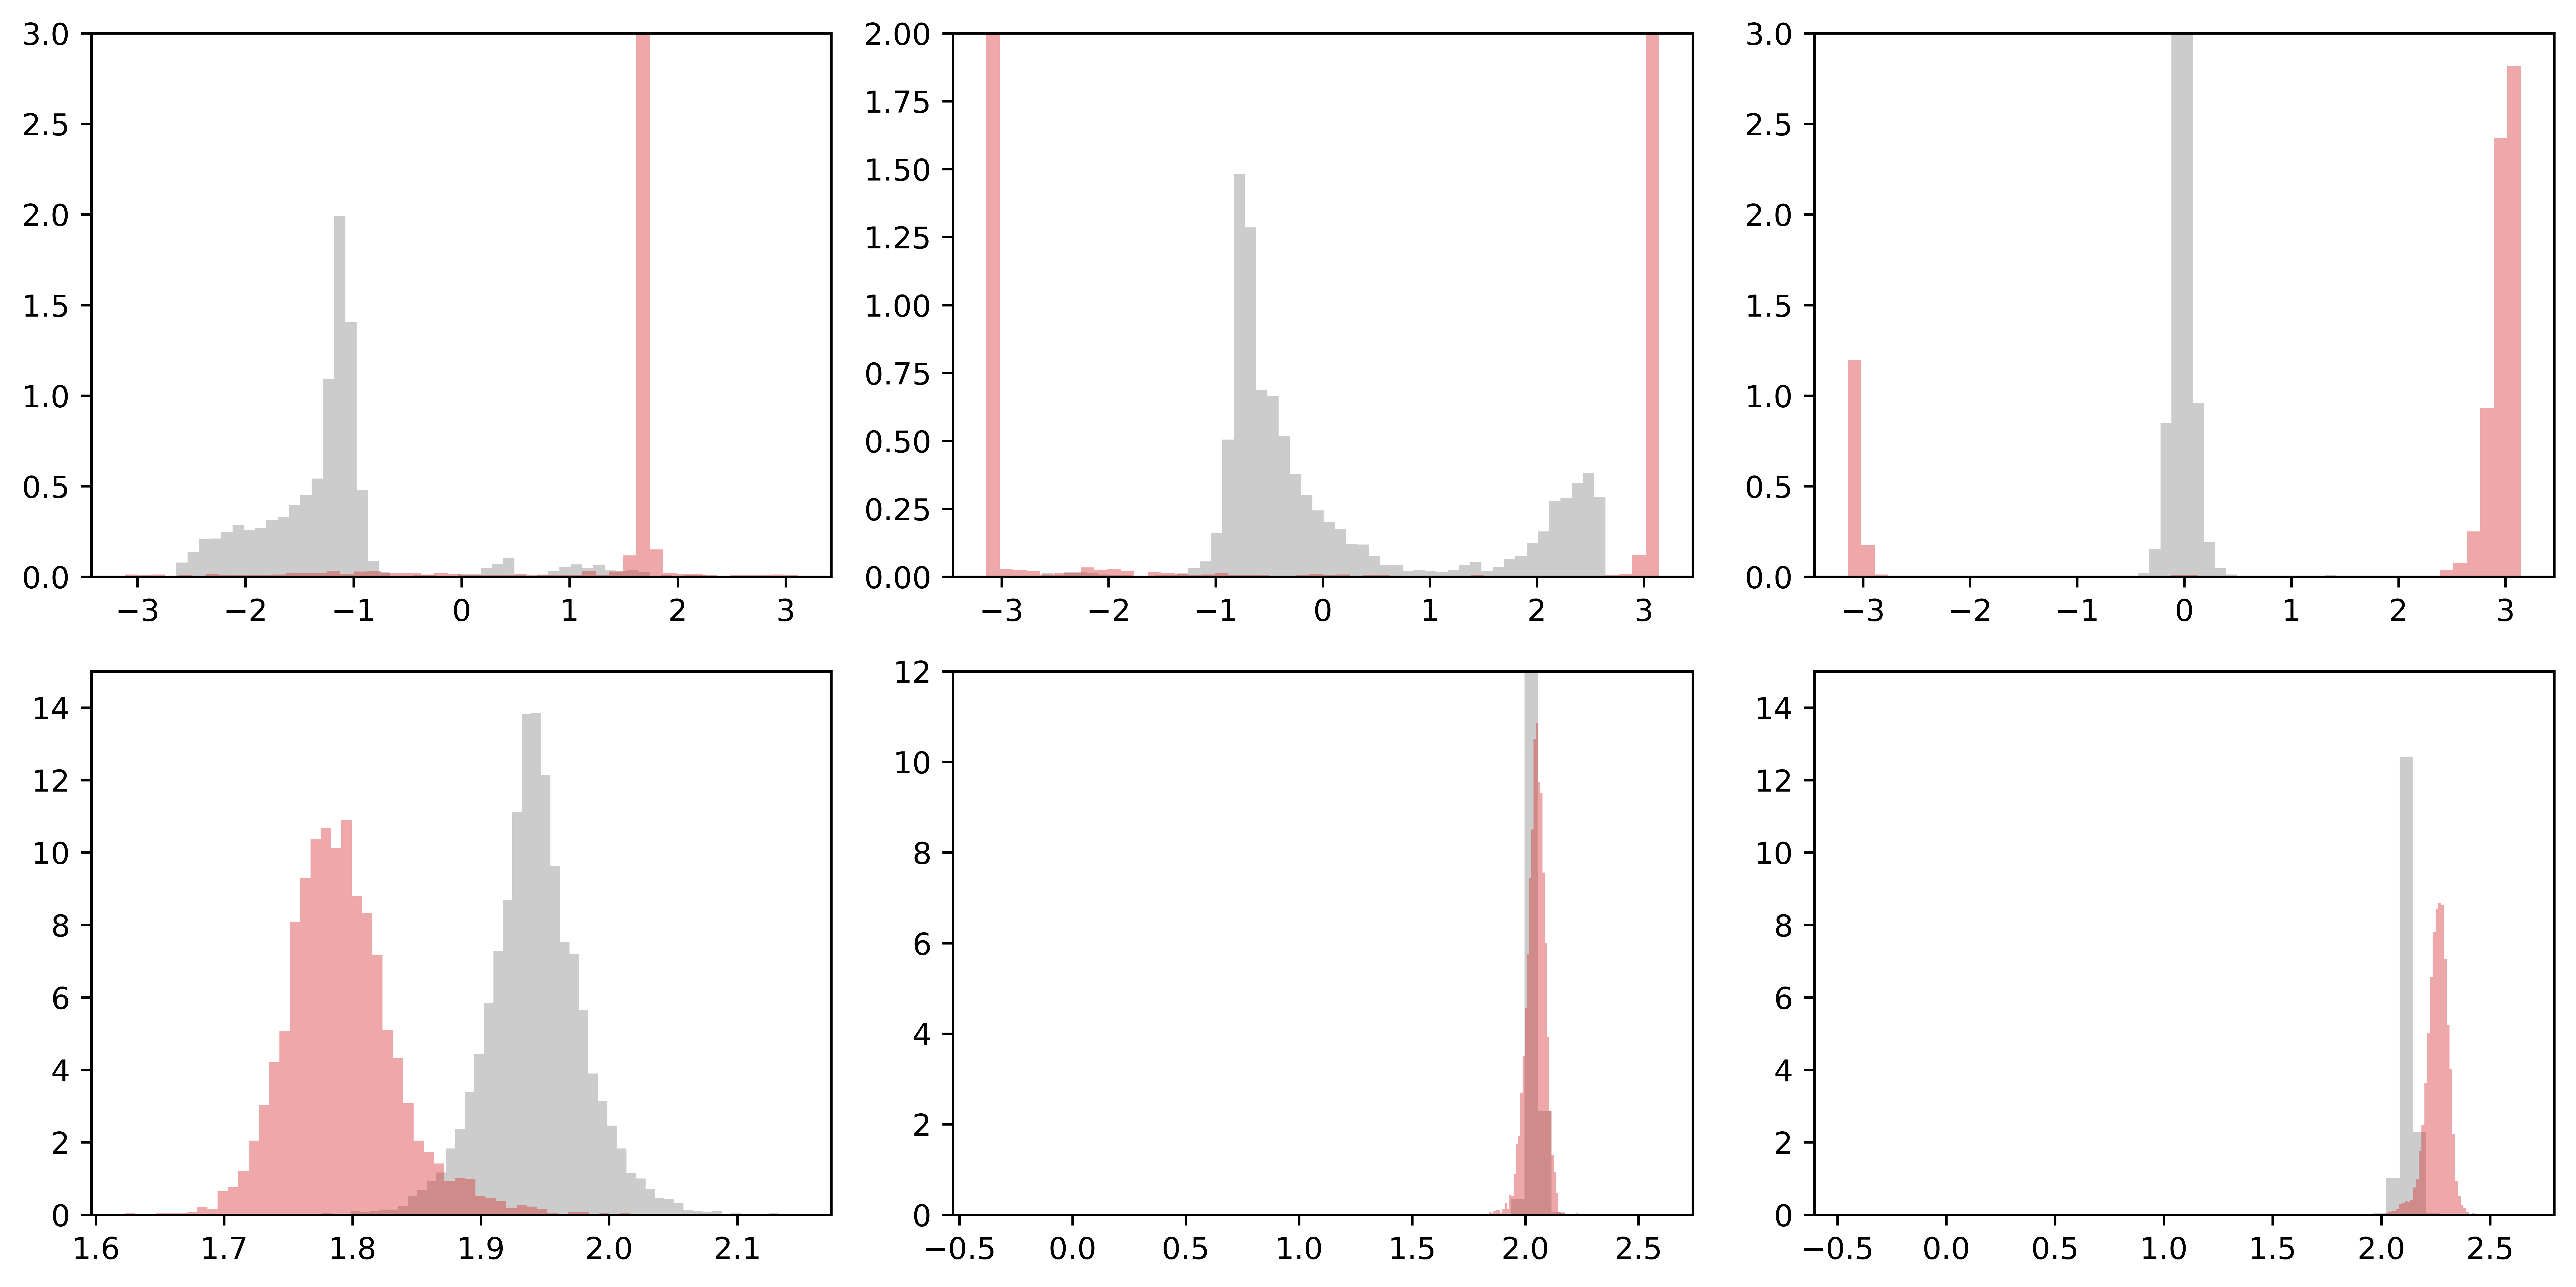

In [53]:
import copy

def modulo_with_wrapped_range(
    vals, range_min: float = -np.pi, range_max: float = np.pi
):
    """
    Modulo with wrapped range -- capable of handing a range with a negative min

    >>> modulo_with_wrapped_range(3, -2, 2)
    -1
    """
    assert range_min <= 0.0
    assert range_min < range_max

    # Modulo after we shift values
    top_end = range_max - range_min
    # Shift the values to be in the range [0, top_end)
    vals_shifted = vals - range_min
    # Perform modulo
    vals_shifted_mod = vals_shifted % top_end
    # Shift back down
    retval = vals_shifted_mod + range_min
    
    mask_pos = (retval-np.pi).abs()<0.5
    mask_neg = (retval+np.pi).abs()<0.5
    retval[mask_pos] = retval[mask_pos]-np.pi
    retval[mask_neg] = retval[mask_neg]+np.pi
    return retval

n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12, 6))
fig.set_dpi(800)


shifted_angles = copy.deepcopy(angles)
shifted_angles['phi_true'] = modulo_with_wrapped_range(shifted_angles['phi_true']+angles['means'][0])
shifted_angles['psi_true'] = modulo_with_wrapped_range(shifted_angles['psi_true']+angles['means'][1])
shifted_angles['omega_true'] = modulo_with_wrapped_range(shifted_angles['omega_true']+angles['means'][2])
shifted_angles['tau_true'] = modulo_with_wrapped_range(shifted_angles['tau_true']+angles['means'][3])
shifted_angles['CA_C_1N_true'] = modulo_with_wrapped_range(shifted_angles['CA_C_1N_true']+angles['means'][4])
shifted_angles['C_1N_1CA_true'] = modulo_with_wrapped_range(shifted_angles['C_1N_1CA_true']+angles['means'][5])

shifted_angles['phi_pred'] = to_real(shifted_angles['phi_pred']+angles['means'][0])
shifted_angles['psi_pred'] = to_real(shifted_angles['psi_pred']+angles['means'][1])
shifted_angles['omega_pred'] = to_real(shifted_angles['omega_pred']+angles['means'][2])
shifted_angles['tau_pred'] = to_real(shifted_angles['tau_pred']+angles['means'][3])
shifted_angles['CA_C_1N_pred'] = to_real(shifted_angles['CA_C_1N_pred']+angles['means'][4])
shifted_angles['C_1N_1CA_pred'] = to_real(shifted_angles['C_1N_1CA_pred']+angles['means'][5])



V_angles_names = ["phi", "psi", "omega", "tau", "CA_C_1N", "C_1N_1CA"]
height = [3,2,3,15,12,15]
for i, idx in enumerate([0,1,2,3,4,5]):
    name = V_angles_names[idx]
    axs[i//3, i%3].hist(shifted_angles[f"{name}_true"], bins=n_bins, alpha=0.4, density=True, label = "True", color = "gray")
    axs[i//3, i%3].hist(shifted_angles[f"{name}_pred"], bins=n_bins, alpha=0.4, density=True, label = "CFoldingDiff", color = "C3")
    
    axs[i//3, i%3].set_ylim([0, height[i]])

In [114]:
import torch
errors = torch.load("/gaozhangyang/experiments/ProreinBinder/results/error_curve_cfolddiff.pt")
import matplotlib.pyplot as plt

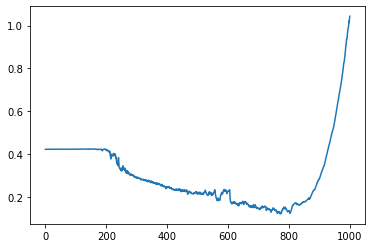

In [124]:
curve = errors['error_curve']
idx = torch.arange(curve.shape[0])
line = curve[:,0].tolist()
plt.plot(idx,  torch.tensor(line)+0.33)
plt.savefig("/gaozhangyang/experiments/ProreinBinder/evaluate/error_curve.png")

In [126]:
(torch.tensor(line)+0.33).mean()

tensor(0.3306)

In [121]:
(torch.tensor(line)+0.33)[-1]

tensor(1.0739)

In [127]:
(torch.tensor(line)+0.33)[0]

tensor(0.4525)

In [101]:
errors = torch.load("/gaozhangyang/experiments/ProreinBinder/results/error_curve_diffsds.pt")

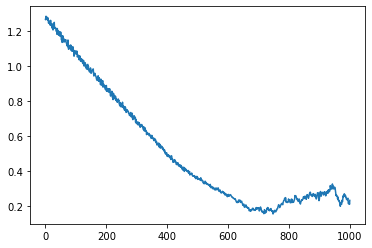

In [102]:
curve = errors['error_curve']
idx = torch.arange(curve.shape[0])
plt.plot(idx,  curve[:,0].abs())
# plt.savefig("/gaozhangyang/experiments/ProreinBinder/evaluate/error_curve.png")